This workbook is for extracting WK255 data and recreating the plots.

File structure: 
```
(root)
├── src
│    └── Python Test.ipynb
└── wairakei_data
     └── Liquid wells (version 1).xlsx
```

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

try:
    xl
except:
    xl = pd.ExcelFile('../wairakei_data/Liquid wells (version 1).xlsx')
print(xl.sheet_names[:5], '...')

['WK26A', 'WK26A trend ', 'WK26A trend  (2)', 'WK26B', 'WK26B trend '] ...


In [22]:
# remove rows at end
df = xl.parse('wk255')
df = df.loc[:, ~df.columns.str.contains('^Unnamed|SUMMARY')]
df['mf'] = pd.to_numeric(df['mf'], errors='coerce')
df = df.dropna(subset=['date', 'whp', 'mf'])
df = df[pd.notnull(df['date'])]
print(df.head())

        date        whp          mf            h      mf eqn     h eqn  \
0 2008-12-18  13.028442  507.776080  1030.000000  508.479408       NaN   
1 2008-12-18  14.841479  283.165920  1030.000000  258.880938       NaN   
2 2008-12-18  14.939021  208.716385  1030.000000  236.661124       NaN   
3 2009-04-08  13.466667  498.071714  1054.230235  495.384693  1051.888   
4 2009-04-08  13.800000  457.879864  1040.519288  462.216261  1044.108   

          diff       whp^2           MF^2  slope  intercept  
0 -1030.000000  169.740297  257836.547309    NaN        NaN  
1 -1030.000000  220.269504   80182.938430    NaN        NaN  
2 -1030.000000  223.174343   43562.529173    NaN        NaN  
3    -2.342235  181.351111  248075.432672    NaN        NaN  
4     3.588712  190.440000  209653.969408    NaN        NaN  


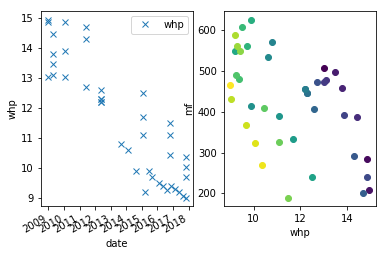

In [130]:
# create exploratory plots

cmap = plt.get_cmap('viridis')
indices = np.linspace(0, cmap.N, len(df))
my_colors = [cmap(int(i)) for i in indices]

fig, (ax1, ax2) = plt.subplots(1,2)

df.plot('date', 'whp', style='x', ax=ax1)
ax1.set_xlabel('date')
ax1.set_ylabel('whp')

for i, idx in enumerate(df.index):
    ax2.plot(df.loc[idx, 'whp'], df.loc[idx, 'mf'], 'o', color=my_colors[i])
# df.plot('whp', 'mf', ax=ax2, style='o')
ax2.set_xlabel('whp')
ax2.set_ylabel('mf')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                     mf   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     75.25
Date:                Sun, 18 Mar 2018   Prob (F-statistic):           6.09e-14
Time:                        23:30:32   Log-Likelihood:                -220.41
No. Observations:                  41   AIC:                             446.8
Df Residuals:                      38   BIC:                             452.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2116.1428    143.629     14.733   

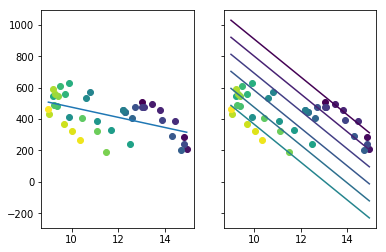

In [133]:
# fit regression model

from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

# method 1
regr = linear_model.LinearRegression()
x = df['whp'].values.reshape(-1,1)
y = df['mf'].values.reshape(-1,1)
regr.fit(x, y)
whp_pred = np.array([np.min(x), np.max(x)]).reshape(-1,1)
yhat = regr.predict(xhat)

# plot
indices = np.linspace(0, cmap.N, len(df))
my_colors = [cmap(int(i)) for i in indices]
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
for i, idx in enumerate(df.index):
    ax1.plot(df.loc[idx, 'whp'], df.loc[idx, 'mf'], 'o', color=my_colors[i])
    ax2.plot(df.loc[idx, 'whp'], df.loc[idx, 'mf'], 'o', color=my_colors[i])

ax1.plot(whp_pred, yhat)

# method 2
# model = ols("mf ~ whp + C(date)", data=df)
# df['date_numeric'] = pd.to_numeric(df['date'])
df['date_numeric'] = (df['date'] - df['date'].min())  / np.timedelta64(1,'D')
model = ols("mf ~ whp + date_numeric", data=df)
results = model.fit()
print(results.summary())

# generate prediction data
date_pred = np.linspace(np.min(df['date_numeric']), np.max(df['date_numeric']), 6)
# date_pred = pd.to_datetime(date_pred)
whp_pred = whp_pred.flatten()
pred = pd.DataFrame(list(product(date_pred, whp_pred)), columns=['date_numeric', 'whp'])

pred['mf'] = results.predict(pred)
print(pred)

# plot
indices = np.linspace(0, cmap.N, len(pred))
my_colors = [cmap(int(i)) for i in indices]
for i, date in enumerate(date_pred):
    ax2.plot(pred['whp'][pred['date_numeric']==date], pred['mf'][pred['date_numeric']==date], color=my_colors[i])


plt.show()